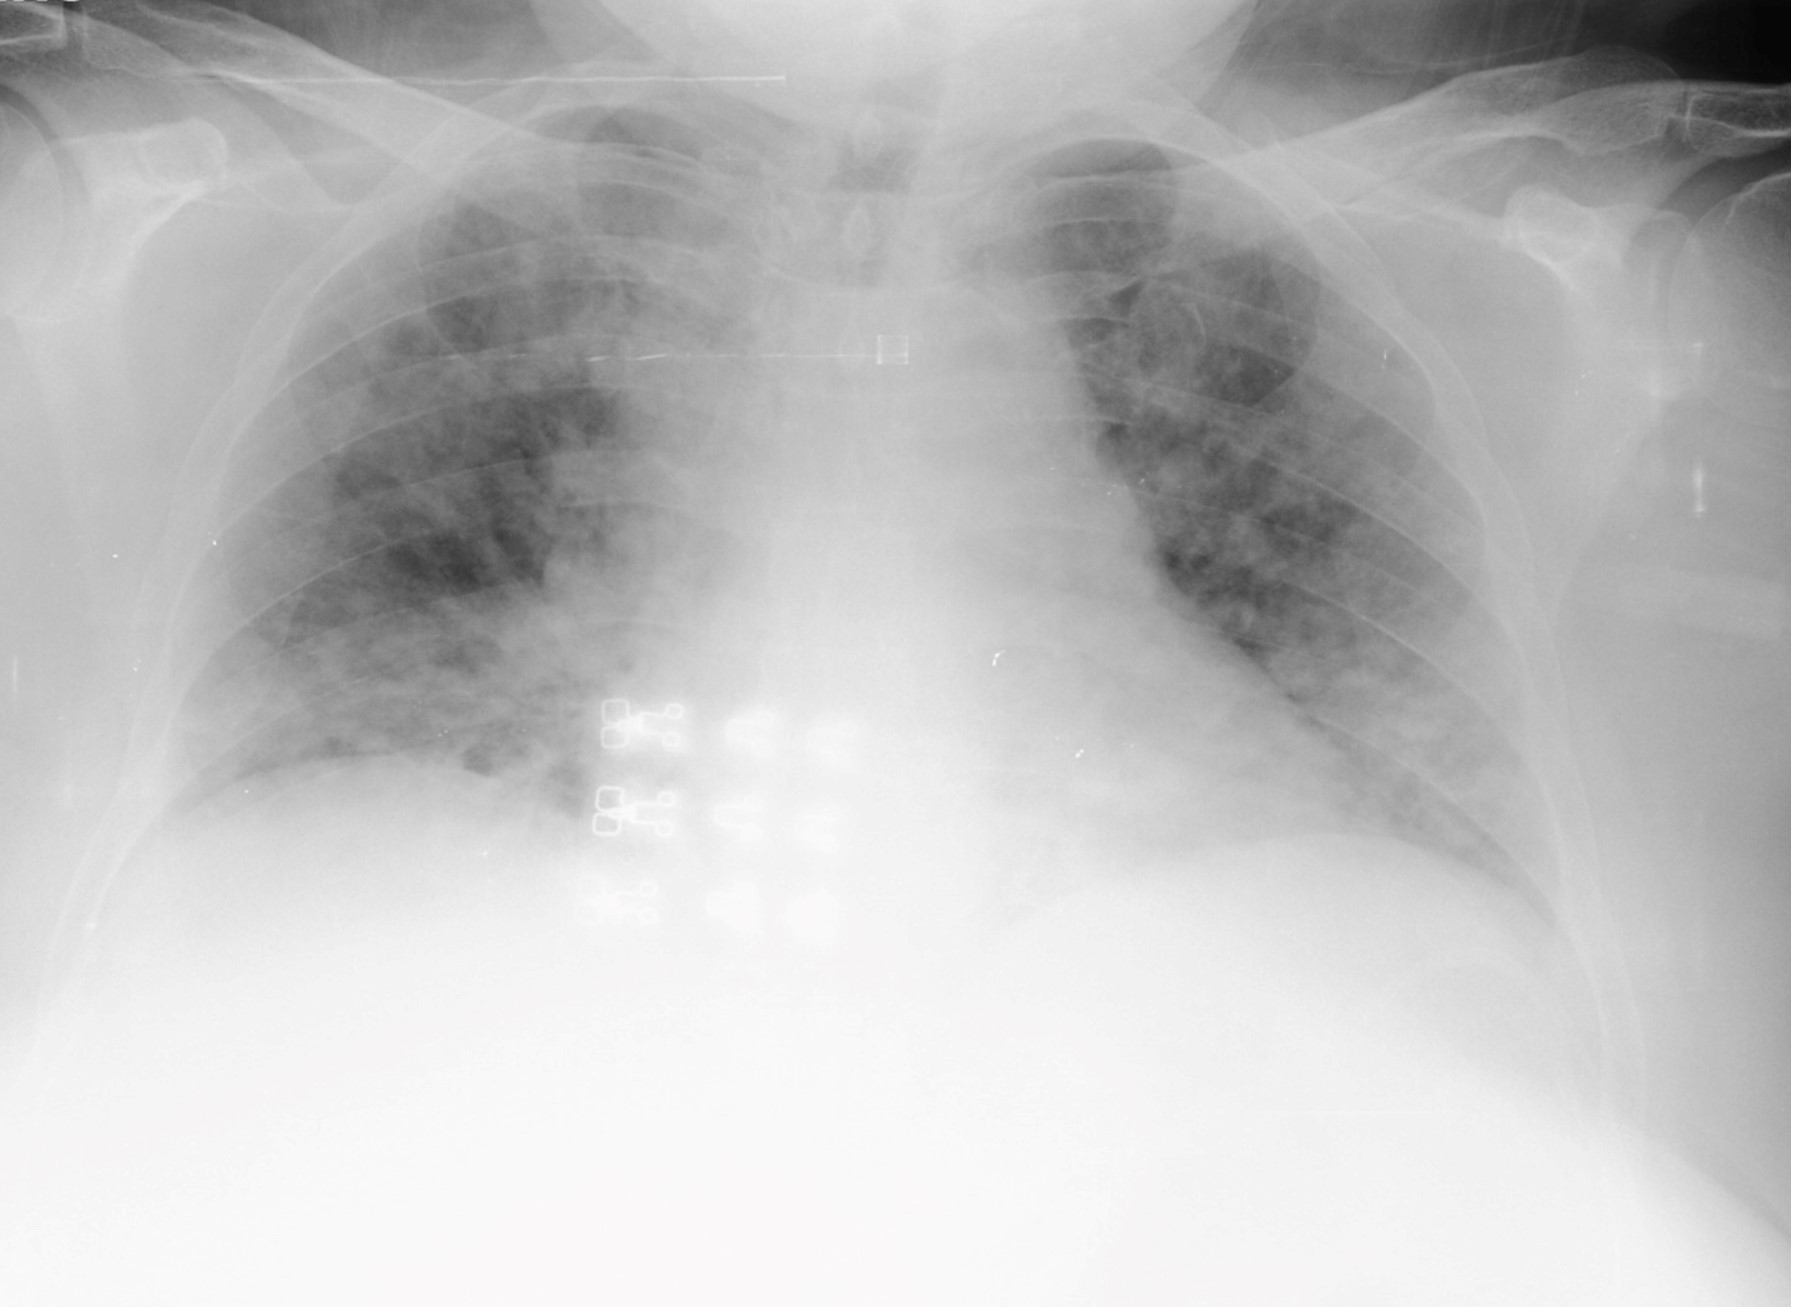

In [1]:
#Importing Libraries
import cv2
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
#Display sample image
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/511 EEE ANC/Severity Part/Severity/COVID_19/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg')
cv2_imshow(image)


In [2]:
#Installing Libraries
!pip install split-folders
import splitfolders

#Splitting the sample data into 70% test, 20% validate and 10% train 
inputf='/content/drive/MyDrive/Colab Notebooks/511 EEE ANC/Severity Part/Severity/samples'
splitfolders.ratio(inputf,output='/content/drive/MyDrive/Colab Notebooks/511 EEE ANC/Severity Part/Severity/Output',seed=42,ratio=(0.7,.2,.1),group_prefix=None)


Copying files: 130 files [00:36,  3.59 files/s]


In [ ]:
#THIS CODE IS EXECUTED IN PERSONAL PC. VIDEO OF EXECUTION IS HERE: https://drive.google.com/file/d/1M6yrfWsRPYbPF4HPlmAeBO8613eX1i20/view?usp=sharing 
#TO EXECUTE THIS CODE, YOU HAVE TO COPY THE COMPLETE CODE IN YOUR .py FILE AND RUN

import cv2
from scipy.stats import itemfreq
import mahotas as mt
import numpy as np
import os
import glob
from sklearn import tree

def extract_features(image):
	# calculate haralick texture features for 4 types of adjacency
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = mt.features.haralick(gray)
	# take the mean of it and return it
    ht_mean  = textures.mean(axis=0)
    arr = np.float32(image)
    pixels = arr.reshape((-1, 3))
    n_colors = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(image.shape)
    dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
    feat = np.concatenate((ht_mean,dominant_color))
    return feat

#from predictionAlgorithm import extract_features

# load the training dataset
train_path  = "ap-or-database/train"
train_names = os.listdir(train_path)

# empty list to hold feature vectors and train labels
train_features = []
train_labels   = []

# loop over the training dataset
for train_name in train_names:
	cur_path = train_path + "/" + train_name
	cur_label = train_name
	i = 1

	for file in glob.glob(cur_path + "/*.jpg"):
		print ("Processing Image - {} in {}".format(i, cur_label))
		# read the training image
		image = cv2.imread(file)

		# extract texture and color from the image
		features = extract_features(image)

		# append the feature vector and label
		train_features.append(features)
		train_labels.append(cur_label)

		# show loop update
		i += 1


# create the classifier
clf=tree.DecisionTreeClassifier()

# train the classifier
print ("Training model..")
clf.fit(train_features, train_labels)

# loop over the test images
test_path = ("ap-or-database/test")
for file in glob.glob(test_path + "/*.jpg"):
	# read the input image
    image = cv2.imread(file)

		# extract texture and color from the image
    features = extract_features(image)

	# evaluate the model and predict label
    prediction = clf.predict(features.reshape(1, -1))[0]

	# show the label
    cv2.putText(image, prediction, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (235,188,0), 3)
    print ("Prediction - {}".format(prediction))

	# display the output image
    cv2.imshow("Test_Image", image)
    cv2.waitKey(0)
cv2.destroyAllWindows()
